In [1]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import Adam
import tensorflow as tf
from tensorflow.keras import layers, models
from tensorflow.keras.optimizers import Adam
import numpy as np
import os
import shutil
import random
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing import image
from tensorflow.keras.callbacks import ModelCheckpoint, EarlyStopping
from tensorflow.keras.layers import Dense, Flatten, Conv2D, MaxPooling2D, Dropout, GlobalAveragePooling2D
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.applications import VGG16, ResNet50, EfficientNetB0


In [2]:
import keras

print("TensorFlow Version:", tf.__version__)
print("Keras Version:", keras.__version__)


TensorFlow Version: 2.17.1
Keras Version: 3.5.0


In [3]:
# Paths
dataset_1 = "/kaggle/input/pcos-detection-using-ultrasound-images/data/train"
dataset_2= "/kaggle/input/pcos-images/Dataset pcos"


In [4]:
# New combined dataset path
combined_dir = "/kaggle/working/dataset"
new_train_dir = "/kaggle/working/train"
new_test_dir = "/kaggle/working/test"

# Create directories
os.makedirs(combined_dir, exist_ok=True)
os.makedirs(new_train_dir, exist_ok=True)
os.makedirs(new_test_dir, exist_ok=True)

# Define the correct class mappings
class_mapping = {
    "notinfected": "Normal",
    "infected": "PCOS",
    "Normal": "Normal",
    "PCOS": "PCOS"
}

In [5]:
# Merge both datasets under the correct class names
for dataset_path in [dataset_1, dataset_2]:
    for class_name in os.listdir(dataset_path):
        original_class_path = os.path.join(dataset_path, class_name)

        # Skip if not a directory
        if not os.path.isdir(original_class_path):
            continue

        # Get the correct class name (mapping infected → PCOS, notinfected → Normal)
        new_class_name = class_mapping.get(class_name, None)
        if new_class_name is None:
            print(f" Warning: Unknown class '{class_name}', skipping.")
            continue

        # Create new class directory in combined dataset
        combined_class_path = os.path.join(combined_dir, new_class_name)
        os.makedirs(combined_class_path, exist_ok=True)

        # Copy images
        for img in os.listdir(original_class_path):
            shutil.copy(os.path.join(original_class_path, img), os.path.join(combined_class_path, img))
# split into train (90%) and test (10%)
for class_name in ["Normal", "PCOS"]:
    class_path = os.path.join(combined_dir, class_name)
    images = os.listdir(class_path)
    random.shuffle(images)

    # Create train/test class folders
    os.makedirs(os.path.join(new_train_dir, class_name), exist_ok=True)
    os.makedirs(os.path.join(new_test_dir, class_name), exist_ok=True)

    # Split 90% train, 10% test
    split_index = int(0.9 * len(images))
    train_images = images[:split_index]
    test_images = images[split_index:]

    # Copy images to new train and test directories
    for img in train_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_train_dir, class_name, img))

    for img in test_images:
        shutil.copy(os.path.join(class_path, img), os.path.join(new_test_dir, class_name, img))

In [6]:
print(f" Train folder: {new_train_dir}")
print(f" Test folder: {new_test_dir}")

 Train folder: /kaggle/working/train
 Test folder: /kaggle/working/test


In [7]:
for class_name in os.listdir(new_train_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_train_dir, class_name)))} train images")
    
for class_name in os.listdir(new_test_dir):
    print(f"{class_name}: {len(os.listdir(os.path.join(new_test_dir, class_name)))} test images")


PCOS: 792 train images
Normal: 1118 train images
PCOS: 89 test images
Normal: 125 test images


In [8]:

# Parameters
batch_size = 128
img_height = img_width =224

In [9]:
# Define data augmentation
train_datagen = ImageDataGenerator(
    rescale=1./255,
    horizontal_flip=True,
    rotation_range=20,
    shear_range=0.2,
    zoom_range=0.2,
    width_shift_range=0.2,
    height_shift_range=0.2,
    validation_split=0.2
)

test_datagen = ImageDataGenerator(rescale=1./255)

In [10]:

train_generator = train_datagen.flow_from_directory(
    new_train_dir, target_size=(224,224), batch_size=batch_size, class_mode='binary', subset="training"
,color_mode="grayscale",seed=12)



test_generator = test_datagen.flow_from_directory(
   new_test_dir,
    target_size=(224,224),
    batch_size=128,
    shuffle= False,
    color_mode="grayscale",
    class_mode='binary'
)

Found 1529 images belonging to 2 classes.
Found 214 images belonging to 2 classes.


In [11]:
from tensorflow.keras import models, layers
from tensorflow.keras.optimizers import Adam

def create_model():
    model = models.Sequential([
        # First Conv Block
        layers.Conv2D(32, (3, 3), activation='relu', padding='same', input_shape=(224, 224, 1)),
        layers.Conv2D(32, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Second Conv Block
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(64, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Third Conv Block
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(128, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fourth Conv Block
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(256, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fifth Conv Block
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.Conv2D(512, (3, 3), activation='relu', padding='same'),
        layers.MaxPooling2D((2, 2)),

        # Fully Connected Layers
        layers.Flatten(),
        layers.Dense(512, activation='relu'),
        layers.Dropout(0.5),
        layers.Dense(256, activation='relu'),
        layers.Dropout(0.3),
        layers.Dense(1, activation='sigmoid')  # Binary classification (Normal vs PCOS)
    ])

    # Compile model
    model.compile(optimizer=Adam(learning_rate=1e-4), loss='binary_crossentropy', metrics=['accuracy'])
    
    return model

# Create the model
model = create_model()

# Model summary
model.summary()


/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                      │ (None, 224, 224, 32)        │             320 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 224, 224, 32)        │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 112, 112, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 112, 112, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 112, 112, 64)        │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 56, 56, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 56, 56, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 56, 56, 128)         │         147,584 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_2 (MaxPooling2D)       │ (None, 28, 28, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 28, 28, 256)         │         590,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_8 (Conv2D)                    │ (None, 14, 14, 512)         │       1,180,160 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_9 (Conv2D)                    │ (None, 14, 14, 512)         │       2,359,808 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 7, 7, 512)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten (Flatten)                    │ (None, 25088)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 512)                 │      12,845,568 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 512)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 256)                 │         131,328 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 256)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 1)                   │             257 │
└──────────────────────────────────────┴─────────────────────────────┴──────────────

 Total params: 17,688,801 (67.48 MB)

 Trainable params: 17,688,801 (67.48 MB)

 Non-trainable params: 0 (0.00 B)

In [12]:
model = create_model()

# Train model
history = model.fit(
    train_generator,  
    epochs=20,
    verbose=1
)


Epoch 1/20


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


12/12 ━━━━━━━━━━━━━━━━━━━━ 67s 3s/step - accuracy: 0.5729 - loss: 0.6870
Epoch 2/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.8014 - loss: 0.5133
Epoch 3/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.8240 - loss: 0.4040
Epoch 4/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 400ms/step - accuracy: 0.8860 - loss: 0.2738
Epoch 5/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 392ms/step - accuracy: 0.9588 - loss: 0.1218
Epoch 6/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 394ms/step - accuracy: 0.9890 - loss: 0.0389
Epoch 7/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 389ms/step - accuracy: 0.9959 - loss: 0.0169
Epoch 8/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 397ms/step - accuracy: 0.9881 - loss: 0.0339
Epoch 9/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step - accuracy: 0.9937 - loss: 0.0236
Epoch 10/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 405ms/step - accuracy: 0.9995 - loss: 0.0061
Epoch 11/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 390ms/step - accuracy: 0.9956 - loss: 0.0084
Epoch 12/20
12/12 ━━━━━━━━━━━━━━━━━━━━ 10s 399ms/step -

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from sklearn.metrics import classification_report, confusion_matrix

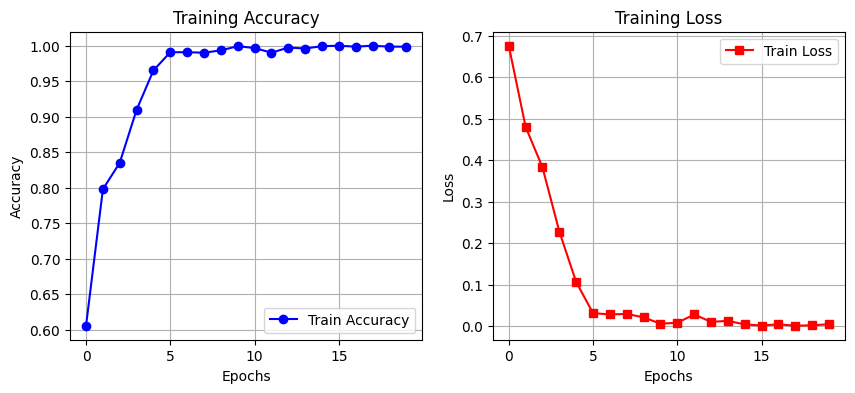

In [14]:

# Create a figure with two subplots
plt.figure(figsize=(10, 4))

# Training Accuracy Plot
plt.subplot(1, 2, 1)
plt.plot(history.history["accuracy"], label="Train Accuracy", marker='o', color='b')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.title("Training Accuracy")
plt.grid(True)

# Training Loss Plot
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Train Loss", marker='s', color='r')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training Loss")
plt.grid(True)

plt.show()


In [15]:
# Evaluate model teat 1
test_loss, test_acc = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

# Make Predictions
y_true = test_generator.classes
y_pred_probs = model.predict(test_generator)
y_pred = (y_pred_probs > 0.5).astype(int)


/usr/local/lib/python3.10/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


2/2 ━━━━━━━━━━━━━━━━━━━━ 17s 6s/step - accuracy: 1.0000 - loss: 5.2943e-04
Test Loss: 0.0004, Test Accuracy: 1.0000
2/2 ━━━━━━━━━━━━━━━━━━━━ 2s 700ms/step


In [16]:
# Classification Report
print("Classification Report:\n", classification_report(y_true, y_pred))

Classification Report:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



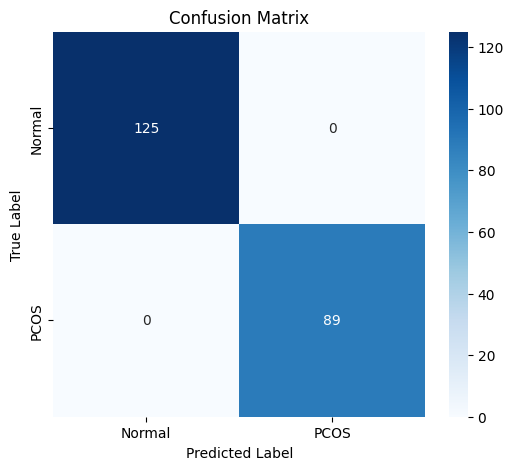

In [17]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.title("Confusion Matrix")
plt.show()

In [18]:
# Define your thresholds
LOW_CONF = 0.4
HIGH_CONF = 0.6

# Get prediction probabilities
y_pred_probs = model.predict(test_generator)

# Interpret predictions
predictions = []
for prob in y_pred_probs:
    if prob < LOW_CONF:
        predictions.append("Normal")
    elif prob > HIGH_CONF:
        predictions.append("PCOS")
    else:
        predictions.append("Uncertain or Invalid Input")

# Print example output
for i, pred in enumerate(predictions[:10]):
    print(f"Image {i+1}: {pred}")


2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 85ms/step
Image 1: Normal
Image 2: Normal
Image 3: Normal
Image 4: Normal
Image 5: Normal
Image 6: Normal
Image 7: Normal
Image 8: Normal
Image 9: Normal
Image 10: Normal


In [19]:
# New predicted class labels (0, 1, or -1 for uncertain)
y_pred = []
for prob in y_pred_probs:
    if prob < LOW_CONF:
        y_pred.append(0)  # Normal
    elif prob > HIGH_CONF:
        y_pred.append(1)  # PCOS
    else:
        y_pred.append(-1)  # Uncertain or Invalid Input


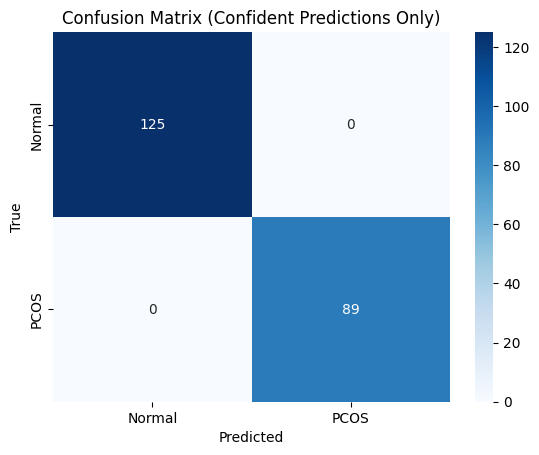

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       125
           1       1.00      1.00      1.00        89

    accuracy                           1.00       214
   macro avg       1.00      1.00      1.00       214
weighted avg       1.00      1.00      1.00       214



In [20]:
# Convert to NumPy for filtering
y_pred = np.array(y_pred)
y_true = np.array(y_true)

# Keep only confident predictions (not -1)
mask = y_pred != -1
y_pred_filtered = y_pred[mask]
y_true_filtered = y_true[mask]

# Confusion Matrix
cm = confusion_matrix(y_true_filtered, y_pred_filtered)
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Normal', 'PCOS'], yticklabels=['Normal', 'PCOS'])
plt.title("Confusion Matrix (Confident Predictions Only)")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

# Report
print(classification_report(y_true_filtered, y_pred_filtered))


In [21]:
total = len(y_pred)
uncertain_count = np.sum(y_pred == -1)
print(f"Uncertain/Invalid inputs: {uncertain_count}/{total} ({100 * uncertain_count / total:.2f}%)")


Uncertain/Invalid inputs: 0/214 (0.00%)


In [22]:
# Save the model
model.save("pcos_model.h5")
print("Model saved as pcos_model.h5")

Model saved as pcos_model.h5
